In [1]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

#Loading the Datasets

In [3]:
df_irrig = pd.read_csv("Irrig_M5_C.csv")

In [4]:
df1 = pd.read_csv("Meteo1_C.csv")
df2 = pd.read_csv("Meteo2_C.csv")
df3 = pd.read_csv("Meteo3_C.csv")
df4 = pd.read_csv("Meteo4_C.csv")
df5 = pd.read_csv("Meteo5_C.csv")

#Data Cleaning

##Irrigation Dataset Cleaning

In [5]:
print(df_irrig['time'].equals(df_irrig['hum_time']))

True


In [6]:
df_irrig = df_irrig.drop(columns=['hum_time'])

In [7]:
df_irrig['depth'] = df_irrig['deviceid'].str.extract(r'_(\d+)$').astype(int) * 10
df_irrig

,deviceid,time,soil temperature,soil moisture,depth
0,pessl_002095C4_1,2020-04-07 12:21:00.000,16.3,0.222,10
1,pessl_002095C4_1,2020-04-07 12:16:00.000,16.0,0.222,10
2,pessl_002095C4_1,2020-04-07 12:31:00.000,16.6,0.222,10
3,pessl_002095C4_1,2020-04-07 12:41:00.000,17.0,0.222,10
4,pessl_002095C4_1,2020-04-07 12:51:00.000,17.4,0.222,10
...,...,...,...,...,...
1471106,pessl_002095C4_6,2025-02-19 01:31:00.000,3.8,0.417,60
1471107,pessl_002095C4_6,2025-02-19 01:41:00.000,3.8,0.417,60
1471108,pessl_002095C4_6,2025-02-19 01:51:00.000,3.7,0.417,60
1471109,pessl_002095C4_6,2025-02-19 02:01:00.000,3.7,0.417,60


#Meteorological dataset preparation

In [8]:
df_combined = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [9]:
df_combined['timestamp_device'] = pd.to_datetime(df_combined['timestamp_device'])
df_combined = df_combined.sort_values(by='timestamp_device').reset_index(drop=True)

In [10]:
# Ensure datetime format
df_combined['timestamp_device'] = pd.to_datetime(df_combined['timestamp_device'])

# Define date range
start_date = '2020-04-07'
end_date = '2025-02-28'

# Filter the DataFrame
df_combined = df_combined[
    (df_combined['timestamp_device'] >= start_date) &
    (df_combined['timestamp_device'] <= end_date)
].reset_index(drop=True)


In [ ]:
df_irrig

,deviceid,time,soil temperature,soil moisture,depth
0,pessl_002095C4_1,2020-04-07 12:21:00.000,16.3,0.222,10
1,pessl_002095C4_1,2020-04-07 12:16:00.000,16.0,0.222,10
2,pessl_002095C4_1,2020-04-07 12:31:00.000,16.6,0.222,10
3,pessl_002095C4_1,2020-04-07 12:41:00.000,17.0,0.222,10
4,pessl_002095C4_1,2020-04-07 12:51:00.000,17.4,0.222,10
...,...,...,...,...,...
1471106,pessl_002095C4_6,2025-02-19 01:31:00.000,3.8,0.417,60
1471107,pessl_002095C4_6,2025-02-19 01:41:00.000,3.8,0.417,60
1471108,pessl_002095C4_6,2025-02-19 01:51:00.000,3.7,0.417,60
1471109,pessl_002095C4_6,2025-02-19 02:01:00.000,3.7,0.417,60


In [11]:
# Rename column to match for merging
df_irrig.rename(columns={'time': 'timestamp_device'}, inplace=True)

# Merge on timestamp
df_merged = pd.merge(df_irrig, df_combined, on='timestamp_device', how='inner')

# Optional: sort and reset index
df_merged = df_merged.sort_values(by='timestamp_device').reset_index(drop=True)

In [12]:
df_merged = df_merged.dropna(axis=1, how="all")
df_merged = df_merged.drop(columns=["par"]) #Dropping columns with ecessive missing values
# Convert to datetime and set index
df_merged['timestamp_device'] = pd.to_datetime(df_merged['timestamp_device'])
df_merged = df_merged.sort_values(by='timestamp_device')
df_merged.set_index('timestamp_device', inplace=True)

# Time-based linear interpolation in both directions
df_merged.interpolate(method='time', limit_direction='both', inplace=True)

# Reset index if needed
df_merged.reset_index(inplace=True)

# Check remaining missing values
print(df_merged.isnull().mean() * 100)

/tmp/ipython-input-12-3437586150.py:9: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_merged.interpolate(method='time', limit_direction='both', inplace=True)


timestamp_device    0.0
deviceid_x          0.0
soil temperature    0.0
soil moisture       0.0
depth               0.0
temperature_c       0.0
humidity_percent    0.0
deviceid_y          0.0
amnt_precp          0.0
leaf_wet            0.0
wind_speed          0.0
battery_voltage     0.0
solar_panel         0.0
wetbulb_t           0.0
drybulb_t           0.0
wind_speed_max2     0.0
radiation           0.0
deltaT              0.0
vpd                 0.0
dew_point           0.0
dtype: float64


In [13]:
df_merged = df_merged.drop(columns=['deviceid_x','deviceid_y'])

In [14]:
# Step 1: Aggregate to remove duplicates
df_agg = df_merged.groupby(['timestamp_device', 'depth']).mean(numeric_only=True)

# Step 2: Unstack depth to make each depth a column
df_wide = df_agg.unstack(level='depth')

# Step 3: Flatten column names
df_wide.columns = [f'{col[0]}_{int(col[1])}cm' for col in df_wide.columns]

# Step 4: Reset index
df_wide.reset_index(inplace=True)

In [ ]:
df_merged

,timestamp_device,soil temperature,soil moisture,depth,temperature_c,humidity_percent,amnt_precp,leaf_wet,wind_speed,battery_voltage,solar_panel,wetbulb_t,drybulb_t,wind_speed_max2,radiation,deltaT,vpd,dew_point
0,2020-04-07 12:16:00,9.2,0.443,40,18.57,12.87,0.0,0.0,0.0,6801.0,10103.0,21.25,24.26,0.0,418.0,12.0,24.7,-1.0
1,2020-04-07 12:16:00,9.2,0.437,60,18.57,12.87,0.0,0.0,0.0,6801.0,10103.0,21.25,24.26,0.0,418.0,12.0,24.7,-1.0
2,2020-04-07 12:16:00,9.4,0.435,50,18.57,12.87,0.0,0.0,0.0,6801.0,10103.0,21.25,24.26,0.0,418.0,12.0,24.7,-1.0
3,2020-04-07 12:16:00,8.8,0.411,30,18.57,12.87,0.0,0.0,0.0,6801.0,10103.0,21.25,24.26,0.0,418.0,12.0,24.7,-1.0
4,2020-04-07 12:16:00,10.6,0.435,20,18.57,12.87,0.0,0.0,0.0,6801.0,10103.0,21.25,24.26,0.0,418.0,12.0,24.7,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503782,2025-02-19 10:01:00,1.1,0.375,20,1.19,39.40,0.0,0.0,1.1,6807.0,10113.0,5.08,5.97,2.3,723.0,4.0,0.4,-11.0
1503783,2025-02-19 10:01:00,1.5,0.405,30,1.19,39.40,0.0,0.0,1.1,6807.0,10113.0,5.08,5.97,2.3,723.0,4.0,0.4,-11.0
1503784,2025-02-19 10:01:00,3.0,0.369,40,1.19,39.40,0.0,0.0,1.1,6807.0,10113.0,5.08,5.97,2.3,723.0,4.0,0.4,-11.0
1503785,2025-02-19 10:01:00,-0.1,0.207,10,1.19,39.40,0.0,0.0,1.1,6807.0,10113.0,5.08,5.97,2.3,723.0,4.0,0.4,-11.0


In [16]:
#Checking multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_merged[['temperature_c', 'humidity_percent', 'amnt_precp', 'leaf_wet', 'wind_speed',
        'wind_speed_max2', 'radiation', 'deltaT', 'vpd', 'dew_point','soil temperature']]
X = add_constant(X)
vif_before = pd.DataFrame()
vif_before["feature"] = X.columns
vif_before["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_before)

             feature         VIF
0              const  356.366713
1      temperature_c   53.687999
2   humidity_percent   20.324428
3         amnt_precp    1.040153
4           leaf_wet    1.247604
5         wind_speed    1.837632
6    wind_speed_max2    1.480932
7          radiation    1.838466
8             deltaT   21.669984
9                vpd    1.923649
10         dew_point   25.014582
11  soil temperature    5.698362


In [17]:
X = df_merged[['temperature_c', 'humidity_percent', 'amnt_precp', 'leaf_wet', 'wind_speed',
        'wind_speed_max2', 'radiation', 'vpd','soil temperature']]
X = add_constant(X)
vif_before = pd.DataFrame()
vif_before["feature"] = X.columns
vif_before["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_before)

            feature        VIF
0             const  56.841247
1     temperature_c   8.334228
2  humidity_percent   3.407143
3        amnt_precp   1.040128
4          leaf_wet   1.227130
5        wind_speed   1.786141
6   wind_speed_max2   1.479444
7         radiation   1.824091
8               vpd   1.691119
9  soil temperature   5.650629


In [19]:
df_merged[['temperature_c', 'soil temperature']].corr()

,temperature_c,soil temperature
temperature_c,1.00000,0.84228
soil temperature,0.84228,1.00000


/tmp/ipython-input-21-2154647624.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_sorted, x="VIF", y="feature", palette="viridis")


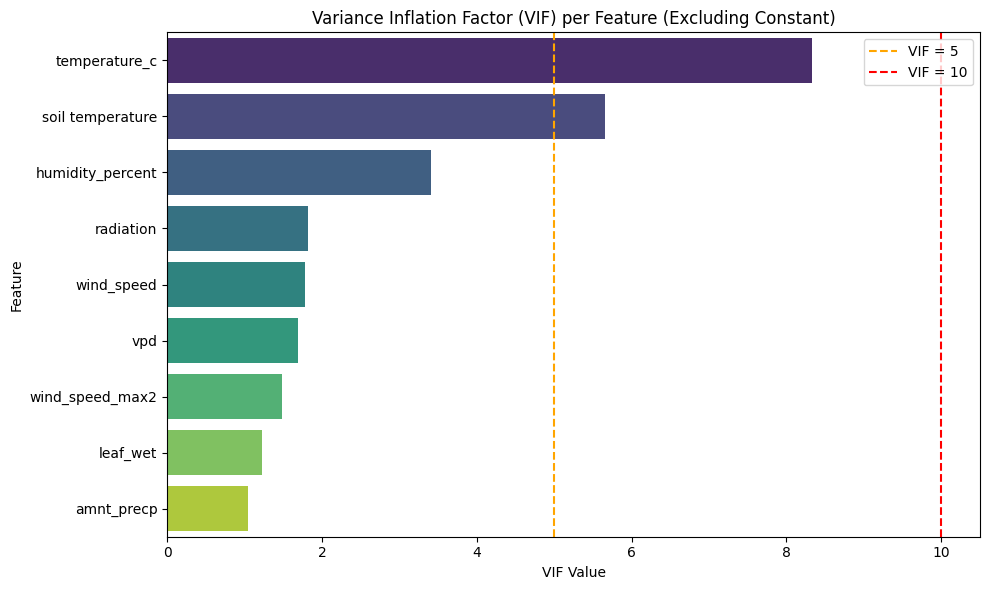

In [21]:
# Remove the constant term
vif_no_const = vif_before[vif_before["feature"] != "const"]

# Optional: Sort by VIF values
vif_sorted = vif_no_const.sort_values("VIF", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=vif_sorted, x="VIF", y="feature", palette="viridis")

# Add reference lines for VIF thresholds
plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5')
plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10')

# Plot styling
plt.title("Variance Inflation Factor (VIF) per Feature (Excluding Constant)")
plt.xlabel("VIF Value")
plt.ylabel("Feature")
plt.legend()
plt.tight_layout()
plt.show()



In [22]:
#Removing Redundant variables
X = df_merged[['temperature_c', 'humidity_percent', 'amnt_precp', 'leaf_wet', 'wind_speed',
        'wind_speed_max2', 'radiation', 'vpd']]
X = add_constant(X)
vif_after = pd.DataFrame()
vif_after["feature"] = X.columns
vif_after["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_after)

            feature        VIF
0             const  55.298153
1     temperature_c   1.942777
2  humidity_percent   2.847479
3        amnt_precp   1.040112
4          leaf_wet   1.215802
5        wind_speed   1.718656
6   wind_speed_max2   1.477650
7         radiation   1.777734
8               vpd   1.691094


/tmp/ipython-input-23-914404937.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_sorted, x="VIF", y="feature", palette="viridis")


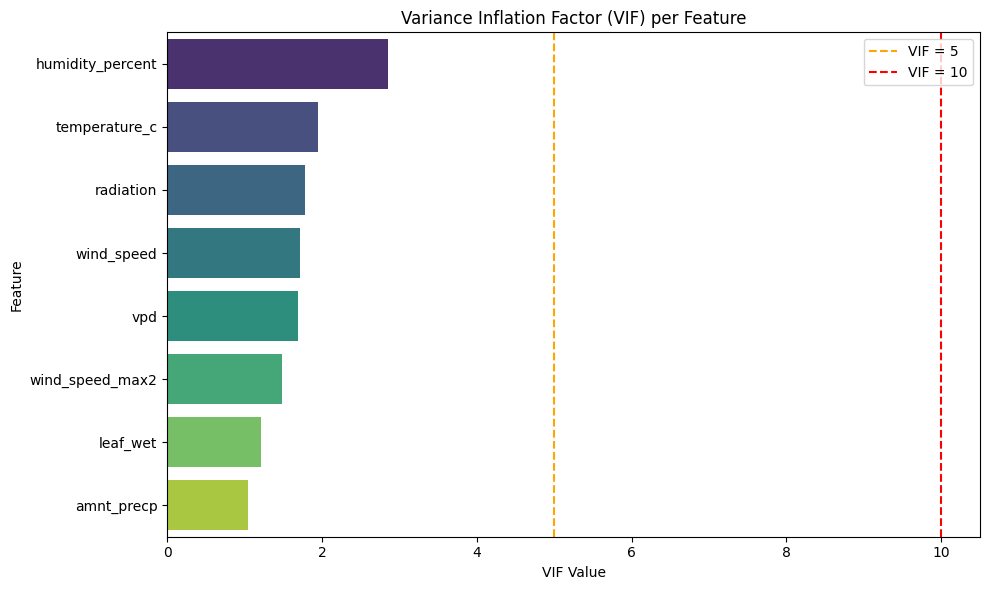

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the constant term
vif_no_const = vif_after[vif_after["feature"] != "const"]

# Optional: Sort by VIF values
vif_sorted = vif_no_const.sort_values("VIF", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=vif_sorted, x="VIF", y="feature", palette="viridis")

# Add reference lines for VIF thresholds
plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5')
plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10')

# Plot styling
plt.title("Variance Inflation Factor (VIF) per Feature")
plt.xlabel("VIF Value")
plt.ylabel("Feature")
plt.legend()
plt.tight_layout()
plt.show()



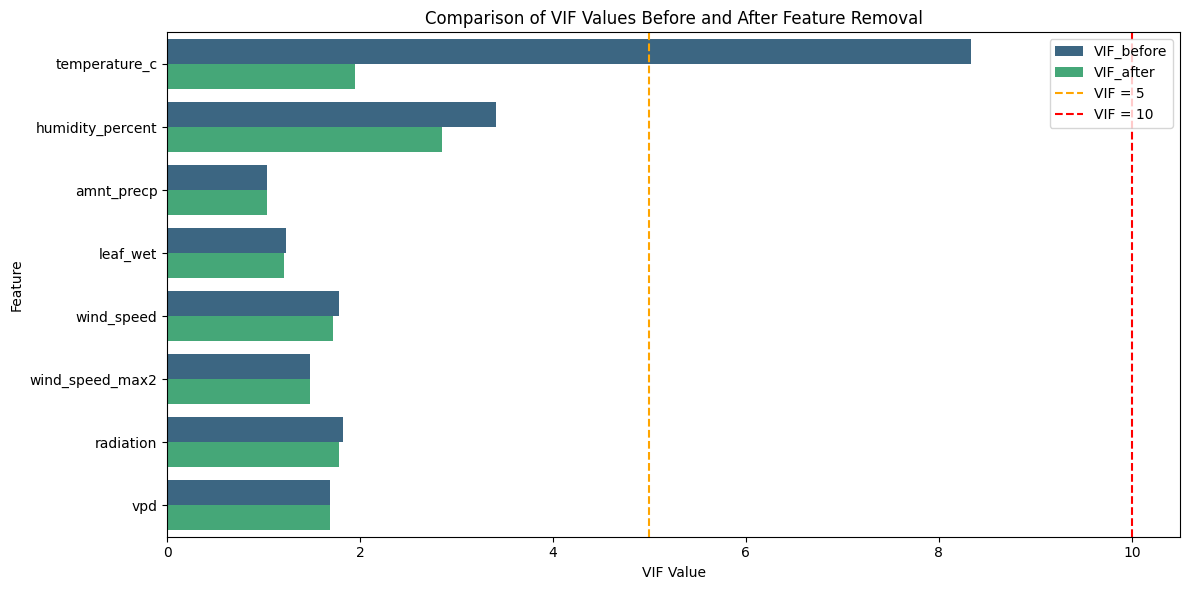

In [24]:
# Prepare the VIF data: remove constants
vif_before_no_const = vif_before[vif_before["feature"] != "const"].copy()
vif_after_no_const = vif_after[vif_after["feature"] != "const"].copy()

# Merge VIFs on feature names
vif_comparison = pd.merge(vif_before_no_const, vif_after_no_const, on="feature", suffixes=('_before', '_after'))

# Melt the DataFrame for plotting
vif_melted = vif_comparison.melt(id_vars='feature',
                                 value_vars=['VIF_before', 'VIF_after'],
                                 var_name='Stage',
                                 value_name='VIF')

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=vif_melted, x='VIF', y='feature', hue='Stage', palette='viridis')

# Add VIF threshold lines
plt.axvline(x=5, color='orange', linestyle='--', label='VIF = 5')
plt.axvline(x=10, color='red', linestyle='--', label='VIF = 10')

# Style the plot
plt.title("Comparison of VIF Values Before and After Feature Removal")
plt.xlabel("VIF Value")
plt.ylabel("Feature")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
#Dataframe Reshaping

# Step 1: Identify depth-dependent variables
depth_vars = ['soil temperature', 'soil moisture']
non_depth_vars = [col for col in df_merged.columns if col not in depth_vars + ['depth']]

# Step 2: Split into depth-dependent and non-depth-dependent
df_depth = df_merged[['timestamp_device', 'depth'] + depth_vars]
df_meta = df_merged[non_depth_vars].drop_duplicates(subset=['timestamp_device'])

# Step 3: Pivot depth-dependent variables using aggregation to resolve duplicates
df_pivot = df_depth.pivot_table(index='timestamp_device', columns='depth', values=depth_vars, aggfunc='mean')

# Step 4: Flatten multi-index columns like ('soil moisture', 10) → 'soil moisture_10cm'
df_pivot.columns = [f"{var}_{int(depth)}cm" for var, depth in df_pivot.columns]

# Step 5: Merge with non-depth variables (meteorological etc.)
df_wide = df_pivot.reset_index().merge(df_meta, on='timestamp_device', how='left')

In [26]:
# Rename soil moisture columns to match desired format: moisture_10cm, moisture_20cm, etc.
df_wide.rename(columns=lambda x: x.replace('soil moisture_', 'moisture_') if 'soil moisture_' in x else x, inplace=True)

In [27]:
# Drop the specified columns from df_wide
columns_to_drop = [
    'soil temperature_10cm', 'soil temperature_20cm', 'soil temperature_30cm',
    'soil temperature_40cm', 'soil temperature_50cm', 'soil temperature_60cm',
    'battery_voltage', 'solar_panel', 'wetbulb_t', 'drybulb_t','dew_point','deltaT'
]

# Drop columns from df_wide
df_wide = df_wide.drop(columns=columns_to_drop, errors='ignore')

In [28]:
# Ensure timestamp is set to datetime
df_wide['timestamp_device'] = pd.to_datetime(df_wide['timestamp_device'])

# Sort by timestamp to ensure proper interpolation
df_wide = df_wide.sort_values(by='timestamp_device')

# Set timestamp as index for time-based interpolation
df_wide.set_index('timestamp_device', inplace=True)

# Apply linear interpolation in both directions
df_wide.interpolate(method='time', limit_direction='both', inplace=True)

# Reset index if needed
df_wide.reset_index(inplace=True)

# Check remaining missing values
print(df_wide.isnull().mean() * 100)

timestamp_device    0.0
moisture_10cm       0.0
moisture_20cm       0.0
moisture_30cm       0.0
moisture_40cm       0.0
moisture_50cm       0.0
moisture_60cm       0.0
temperature_c       0.0
humidity_percent    0.0
amnt_precp          0.0
leaf_wet            0.0
wind_speed          0.0
wind_speed_max2     0.0
radiation           0.0
vpd                 0.0
dtype: float64


In [29]:
#Checking for irregularities in time intervals between records

# Sort by timestamp to ensure correct time order
df_wide = df_wide.sort_values('timestamp_device')

# Calculate time difference between consecutive timestamps
df_wide['time_diff'] = df_wide['timestamp_device'].diff()

# Check most common interval (mode)
interval_mode = df_wide['time_diff'].mode()[0]
print(f"Most common time interval: {interval_mode}")

# Find rows with inconsistent intervals
inconsistent_intervals = df_wide[df_wide['time_diff'] != interval_mode]
print(f"Number of inconsistent intervals: {len(inconsistent_intervals)}")

# Optional: Display them
print(inconsistent_intervals[['timestamp_device', 'time_diff']])


Most common time interval: 0 days 00:10:00
Number of inconsistent intervals: 102006
          timestamp_device       time_diff
0      2020-04-07 12:16:00             NaT
1      2020-04-07 12:21:00 0 days 00:05:00
592    2020-04-11 15:01:00 0 days 00:20:00
600    2020-04-11 16:31:00 0 days 00:20:00
608    2020-04-11 18:01:00 0 days 00:20:00
...                    ...             ...
244127 2025-02-18 06:21:00 0 days 00:05:00
244151 2025-02-18 10:16:00 0 days 00:05:00
244152 2025-02-18 10:21:00 0 days 00:05:00
244271 2025-02-19 06:16:00 0 days 00:15:00
244272 2025-02-19 06:21:00 0 days 00:05:00

[102006 rows x 2 columns]


In [ ]:
# Filter from 2023 onwards
df_2023 = df_wide[df_wide['timestamp_device'] >= '2023-01-01'].copy()

# Sort by timestamp in case it's not sorted
df_2023 = df_2023.sort_values('timestamp_device')

# Calculate time differences between consecutive entries
df_2023['time_diff_calc'] = df_2023['timestamp_device'].diff()

# Count total time differences (excluding the first NaT)
total_diffs = df_2023['time_diff_calc'].iloc[1:].shape[0]

# Count how many are not exactly 10 minutes
non_10min_diffs = df_2023[df_2023['time_diff_calc'] != pd.Timedelta(minutes=10)].shape[0]

# Calculate percentage
percentage_non_10min = (non_10min_diffs / total_diffs) * 100

print(f"Percentage of time intervals ≠ 10 minutes from 2023 onward: {percentage_non_10min:.2f}%")


Percentage of time intervals ≠ 10 minutes from 2023 onward: 44.18%


In [ ]:
df_wide

,timestamp_device,moisture_10cm,moisture_20cm,moisture_30cm,moisture_40cm,moisture_50cm,moisture_60cm,temperature_c,humidity_percent,amnt_precp,leaf_wet,wind_speed,wind_speed_max2,radiation,vpd,time_diff
0,2020-04-07 12:16:00,0.222,0.435,0.411,0.443,0.435,0.437,18.57,12.87,0.0,0.0,0.0,0.0,418.0,24.70,NaT
1,2020-04-07 12:21:00,0.222,0.435,0.411,0.443,0.435,0.437,18.07,12.80,0.0,0.0,2.2,3.9,418.0,24.70,0 days 00:05:00
2,2020-04-07 12:31:00,0.222,0.434,0.411,0.443,0.435,0.437,18.51,14.34,0.0,0.0,1.9,3.8,418.0,24.70,0 days 00:10:00
3,2020-04-07 12:41:00,0.222,0.435,0.411,0.443,0.435,0.437,18.29,12.43,0.0,0.0,1.9,4.1,418.0,24.70,0 days 00:10:00
4,2020-04-07 12:51:00,0.222,0.435,0.411,0.443,0.435,0.437,18.54,14.68,0.0,0.0,1.6,5.0,418.0,24.70,0 days 00:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244290,2025-02-19 09:21:00,0.201,0.375,0.405,0.369,0.409,0.417,0.81,38.78,0.0,0.0,0.5,2.0,676.0,0.39,0 days 00:10:00
244291,2025-02-19 09:31:00,0.202,0.375,0.405,0.369,0.409,0.417,0.84,36.66,0.0,0.0,0.8,2.6,691.0,0.41,0 days 00:10:00
244292,2025-02-19 09:41:00,0.203,0.375,0.405,0.369,0.409,0.417,1.13,36.79,0.0,0.0,1.0,2.9,700.0,0.41,0 days 00:10:00
244293,2025-02-19 09:51:00,0.205,0.375,0.405,0.369,0.409,0.417,1.22,36.84,0.0,0.0,1.0,3.5,706.0,0.41,0 days 00:10:00


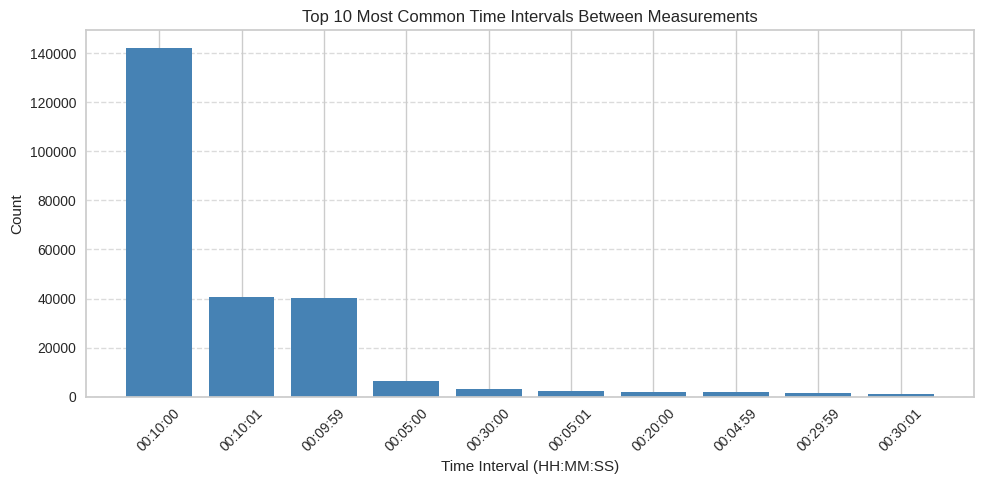

In [ ]:
# Sort by timestamp
df_wide = df_wide.sort_values('timestamp_device')

# Calculate time difference
df_wide['time_diff'] = df_wide['timestamp_device'].diff()

# Count and get top 10 intervals
top_intervals = df_wide['time_diff'].value_counts().nlargest(10)

# Format index to HH:MM:SS
formatted_labels = top_intervals.index.map(lambda x: str(x).split()[-1])  # strips "0 days" or shows only time

# Plot with cleaned labels
plt.figure(figsize=(10, 5))
plt.bar(formatted_labels, top_intervals.values, color='steelblue')
plt.title('Top 10 Most Common Time Intervals Between Measurements')
plt.xlabel('Time Interval (HH:MM:SS)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


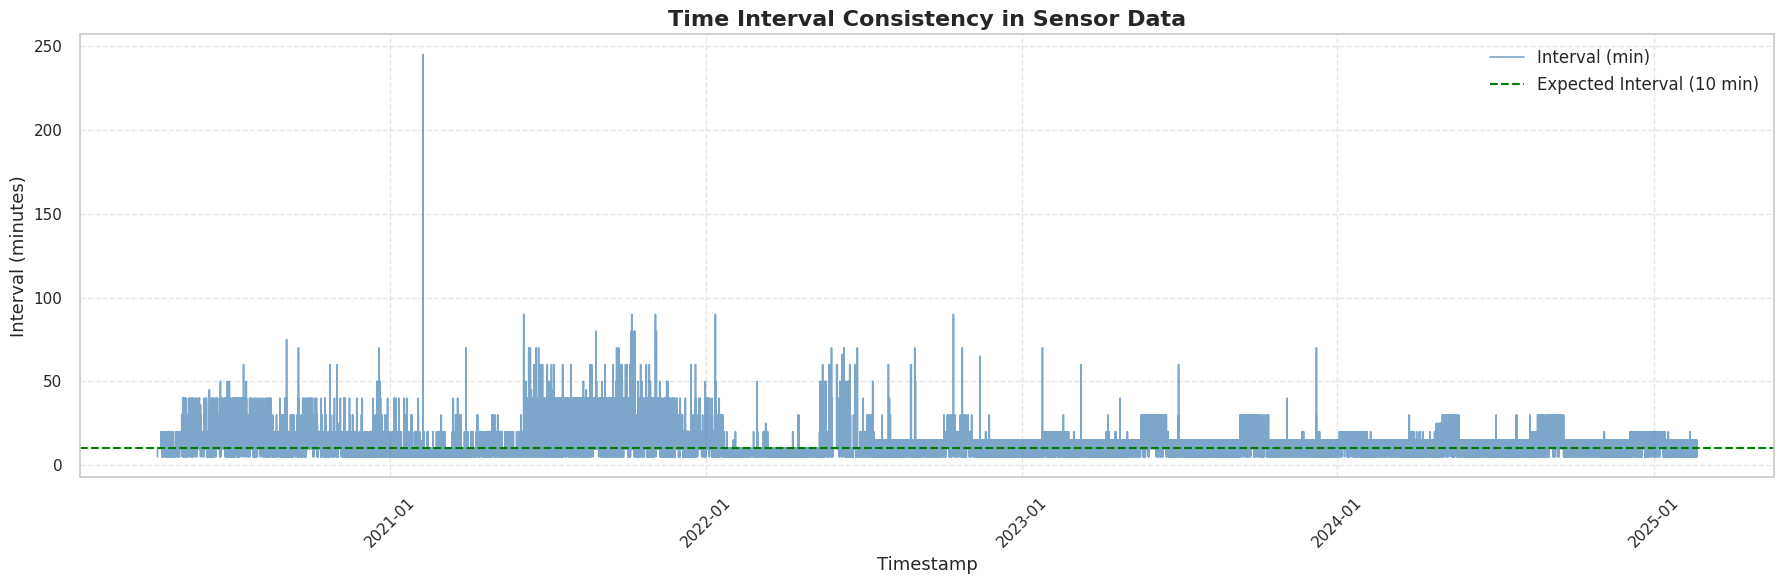

In [ ]:
import matplotlib.dates as mdates

#Prepare the Data
df_wide = df_wide.sort_values('timestamp_device')
df_wide['time_diff_min'] = df_wide['timestamp_device'].diff().dt.total_seconds() / 60

# Identify irregular intervals (not equal to 10)
irregular = df_wide[df_wide['time_diff_min'] != 10]

#Plotting
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 6))

# Line plot for all intervals
plt.plot(df_wide['timestamp_device'], df_wide['time_diff_min'],
         label='Interval (min)', color='steelblue', linewidth=1.2, alpha=0.7)

# Horizontal line for expected interval
plt.axhline(10, color='green', linestyle='--', linewidth=1.5, label='Expected Interval (10 min)')

plt.title('Time Interval Consistency in Sensor Data', fontsize=16, fontweight='bold')
plt.xlabel('Timestamp', fontsize=13)
plt.ylabel('Interval (minutes)', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Format x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Resampling to ten minutes intervals
# Copy the dataframe
base_df = df_wide.copy()

# Drop the 'time_diff' column (and 'time_diff_min' if you want, since it seems related)
base_df = base_df.drop(columns=['time_diff', 'time_diff_min'], errors='ignore')

# Make sure timestamp_device is datetime index (you said it already is, but just in case)
base_df.index = pd.to_datetime(base_df.index)

# Resample to 10-minute intervals and take mean
base_df_resampled = base_df.resample('10T').mean()

# Interpolate only numeric columns (should be all columns now since time_diff is dropped)
base_df_resampled = base_df_resampled.interpolate(method='time')

# Reset index if you want timestamp_device as a column again
base_df_resampled.reset_index(inplace=True)

print(base_df_resampled.head())

     timestamp_device  moisture_10cm  moisture_20cm  moisture_30cm  \
0 2020-04-07 12:10:00          0.222          0.435          0.411   
1 2020-04-07 12:20:00          0.222          0.435          0.411   
2 2020-04-07 12:30:00          0.222          0.434          0.411   
3 2020-04-07 12:40:00          0.222          0.435          0.411   
4 2020-04-07 12:50:00          0.222          0.435          0.411   

   moisture_40cm  moisture_50cm  moisture_60cm  temperature_c  \
0          0.443          0.435          0.437          18.57   
1          0.443          0.435          0.437          18.07   
2          0.443          0.435          0.437          18.51   
3          0.443          0.435          0.437          18.29   
4          0.443          0.435          0.437          18.54   

   humidity_percent  amnt_precp  leaf_wet  wind_speed  wind_speed_max2  \
0             12.87         0.0       0.0         0.0              0.0   
1             12.80         0.0       0.

In [ ]:
base_df_resampled

,timestamp_device,moisture_10cm,moisture_20cm,moisture_30cm,moisture_40cm,moisture_50cm,moisture_60cm,temperature_c,humidity_percent,amnt_precp,leaf_wet,wind_speed,wind_speed_max2,radiation,vpd
0,2020-04-07 12:10:00,0.222,0.435,0.411,0.443,0.435,0.437,18.57,12.87,0.0,0.0,0.0,0.0,418.0,24.70
1,2020-04-07 12:20:00,0.222,0.435,0.411,0.443,0.435,0.437,18.07,12.80,0.0,0.0,2.2,3.9,418.0,24.70
2,2020-04-07 12:30:00,0.222,0.434,0.411,0.443,0.435,0.437,18.51,14.34,0.0,0.0,1.9,3.8,418.0,24.70
3,2020-04-07 12:40:00,0.222,0.435,0.411,0.443,0.435,0.437,18.29,12.43,0.0,0.0,1.9,4.1,418.0,24.70
4,2020-04-07 12:50:00,0.222,0.435,0.411,0.443,0.435,0.437,18.54,14.68,0.0,0.0,1.6,5.0,418.0,24.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256159,2025-02-19 09:20:00,0.201,0.375,0.405,0.369,0.409,0.417,0.81,38.78,0.0,0.0,0.5,2.0,676.0,0.39
256160,2025-02-19 09:30:00,0.202,0.375,0.405,0.369,0.409,0.417,0.84,36.66,0.0,0.0,0.8,2.6,691.0,0.41
256161,2025-02-19 09:40:00,0.203,0.375,0.405,0.369,0.409,0.417,1.13,36.79,0.0,0.0,1.0,2.9,700.0,0.41
256162,2025-02-19 09:50:00,0.205,0.375,0.405,0.369,0.409,0.417,1.22,36.84,0.0,0.0,1.0,3.5,706.0,0.41


In [ ]:
#Filterdataframe to minimize extreme irregular resampled intervals
# Ensure timestamp_device is datetime
base_df_resampled['timestamp_device'] = pd.to_datetime(base_df_resampled['timestamp_device'])
base_df_resampled.set_index('timestamp_device', inplace=True)

# Filter for years 2023 to 2025
filtered_df = base_df_resampled.loc['2023':'2025']

# Optional: reset index if needed
filtered_df = filtered_df.reset_index()

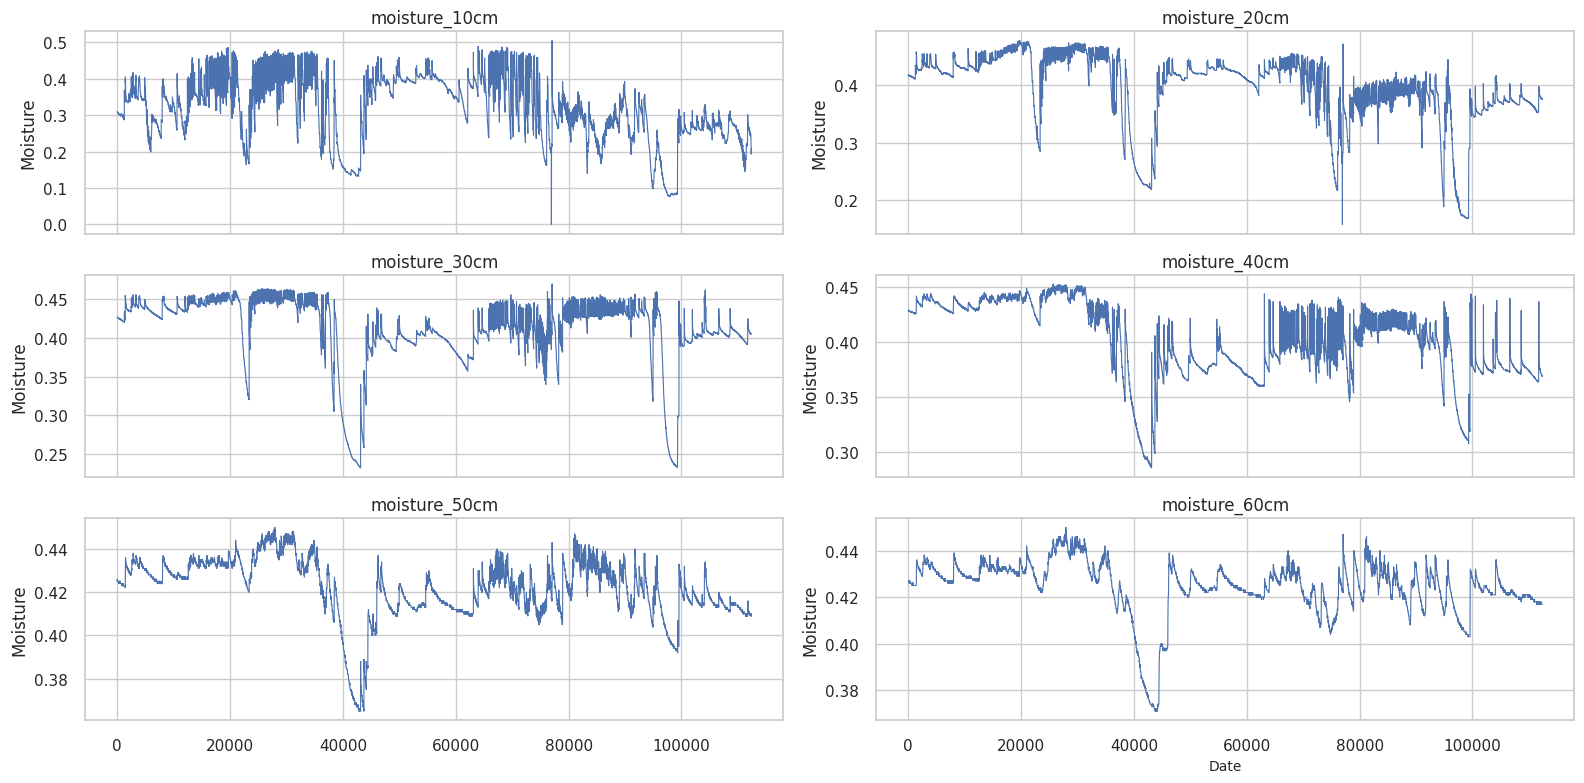

In [ ]:
#Check moisture evolution at each depth
# Moisture columns
moisture_columns = ['moisture_10cm', 'moisture_20cm', 'moisture_30cm',
                    'moisture_40cm', 'moisture_50cm', 'moisture_60cm']

# Create 3 rows × 2 columns of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 8), sharex=True)
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Plot each column
for i, col in enumerate(moisture_columns):
    axes[i].plot(filtered_df.index, filtered_df[col], linewidth=0.8)
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Moisture')
    axes[i].grid(True)

# Set common X label
plt.xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

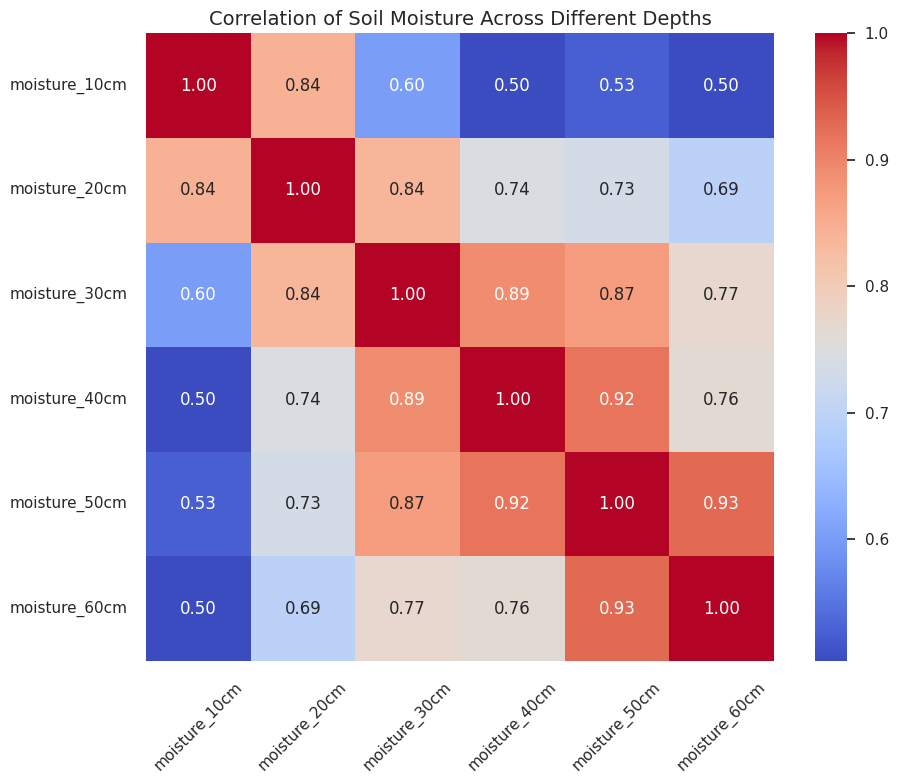

In [ ]:
#Checking correlations between depths
# Select only the soil moisture columns
moisture_columns = [col for col in filtered_df.columns if col.startswith("moisture_")]
moisture_df = filtered_df[moisture_columns]

# Compute the correlation matrix
correlation_matrix = moisture_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation of Soil Moisture Across Different Depths", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


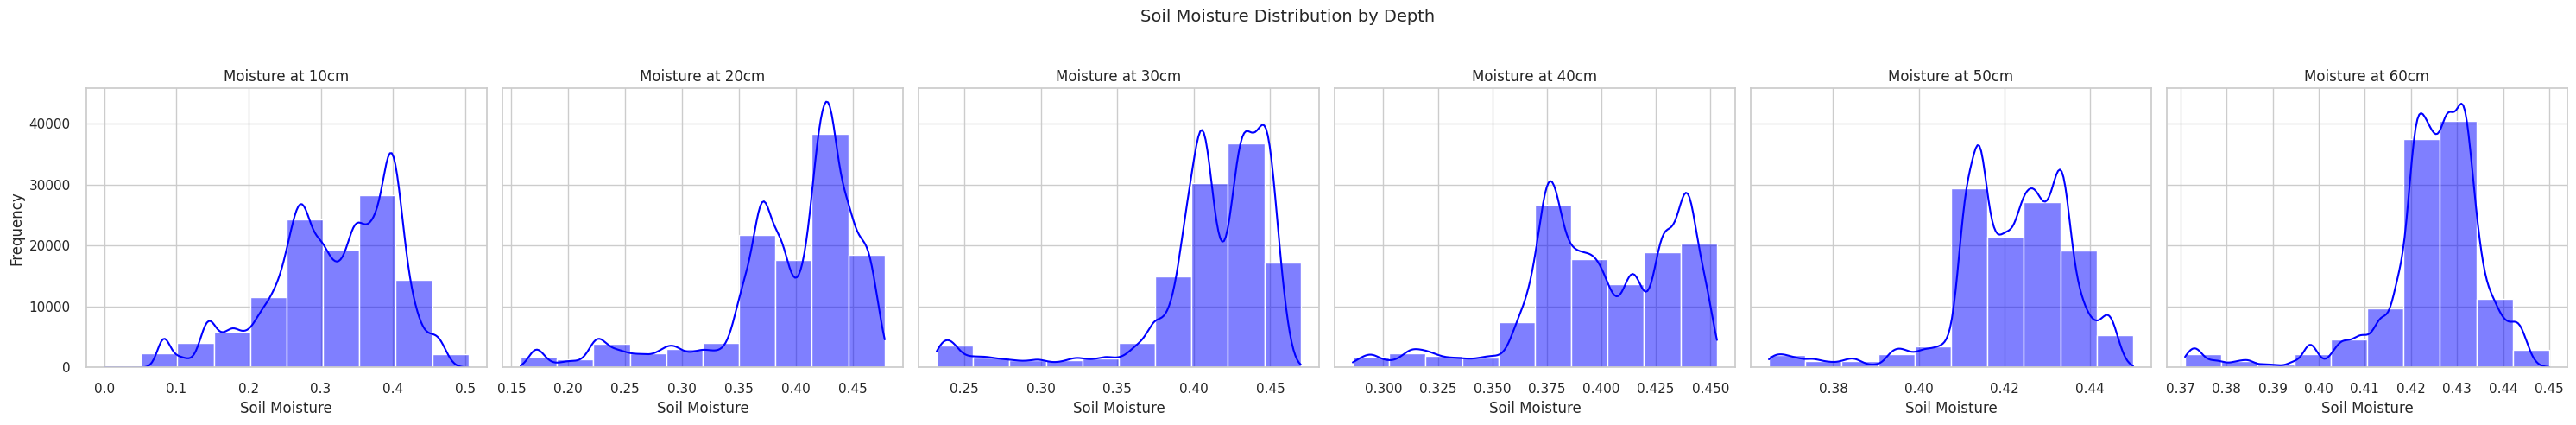

In [ ]:
#Checking the distribution of moisture levels accross depths
# Ensure seaborn aesthetics
sns.set(style="whitegrid")

# Reshape the DataFrame to long format for easier plotting
moisture_columns = [col for col in filtered_df.columns if col.startswith("moisture_")]
df_long = filtered_df.melt(
    id_vars=["timestamp_device"],
    value_vars=moisture_columns,
    var_name="depth",
    value_name="soil moisture"
)

# Extract numeric depth value (e.g., "moisture_10cm" → 10)
df_long["depth"] = df_long["depth"].str.extract(r'(\d+)').astype(int)

# Plot moisture histograms by depth
def plot_moisture_histograms_row(df):
    depths = sorted(df['depth'].unique())
    n = len(depths)

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)
    if n == 1:
        axes = [axes]  # Ensure iterable if only one subplot

    for i, depth in enumerate(depths):
        subset = df[df['depth'] == depth]
        sns.histplot(subset['soil moisture'], bins=10, kde=True, color='blue', ax=axes[i])
        axes[i].set_title(f"Moisture at {depth}cm")
        axes[i].set_xlabel("Soil Moisture")
        axes[i].set_ylabel("Frequency")

    plt.suptitle(f"Soil Moisture Distribution by Depth", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Use the function on the filtered dataset
plot_moisture_histograms_row(df_long)